# imports and initialization

In [1]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib
from g2p_en import G2p

from nejm_b2txt_utils.general_utils import *

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'

g2p = G2p()

# load Copy Task evaluation data

In [2]:
# load pickled data
with open('../data/t15_copyTask.pkl', 'rb') as f:
    dat = pickle.load(f)

# plot decoded phoneme logits from an example trial

cue words:               they can pretty much get everybody there
cue phonemes:            DH EY  |  K AE N  |  P R IH T IY  |  M AH CH  |  G EH T  |  EH V R IY B AA D IY  |  DH EH R  | 
decoded phonemes (raw):  DH EY  |  K AE N  |  B R IH T IY  |  M AH N CH  |  G EH T  |  EH V R IY B AA D IY  |  DH EH R  | 
decoded words:           they can pretty much get everybody there
decoded phonemes:        DH EY  |  K AE N  |  P R IH T IY  |  M AH CH  |  G EH T  |  EH V R IY B AA D IY  |  DH EH R  | 


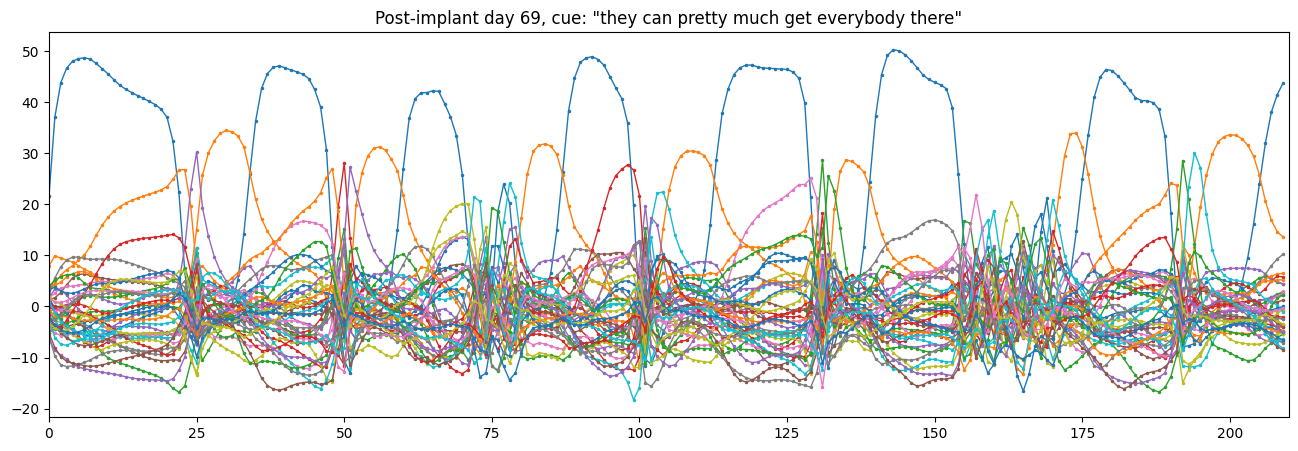

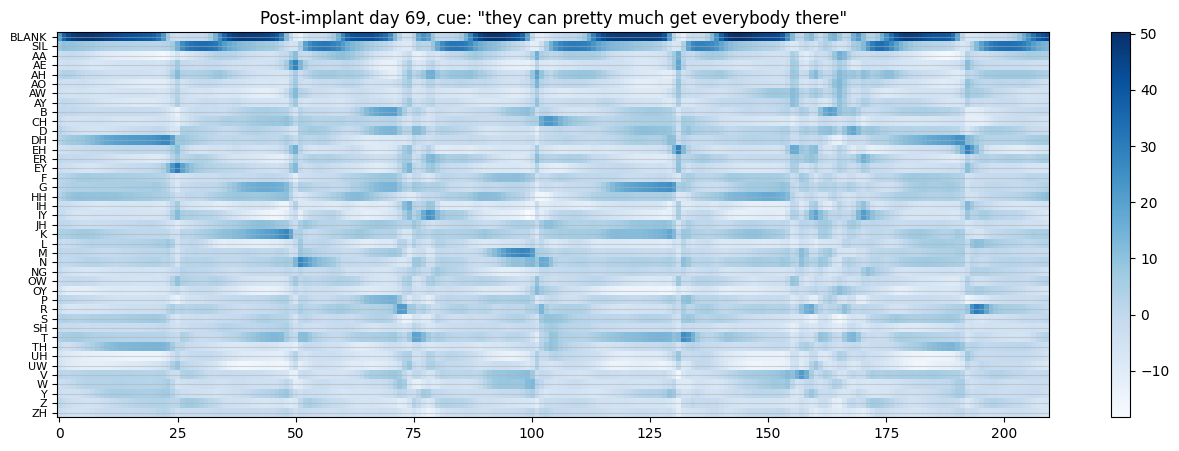

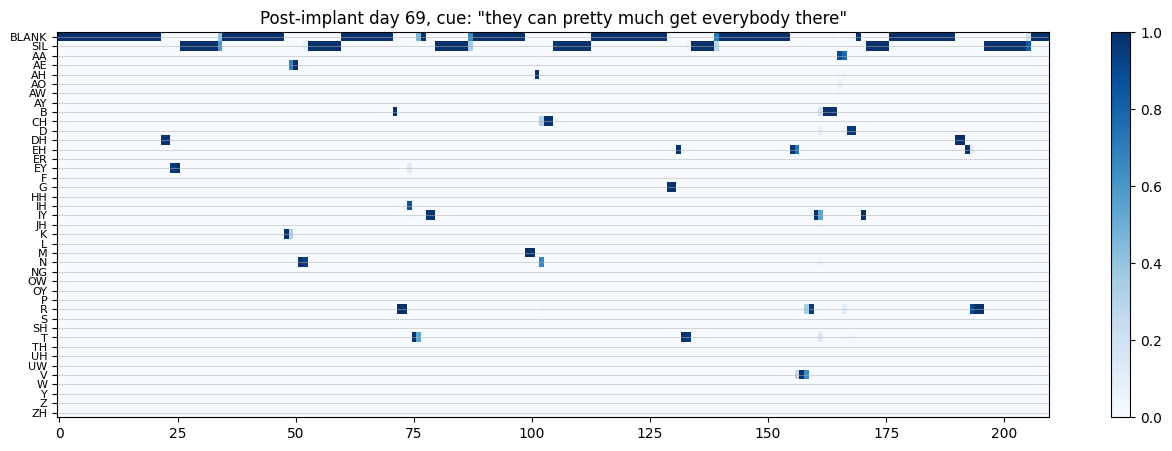

In [3]:
trl = 500

print(f"cue words:               {dat['cue_sentence'][trl]}")
print(f"cue phonemes:            {' '.join(dat['cue_sentence_phonemes'][trl]).replace('SIL',' | ')}")
print(f"decoded phonemes (raw):  {' '.join(dat['decoded_phonemes_raw'][trl]).replace('SIL',' | ')}")
print(f"decoded words:           {dat['decoded_sentence'][trl]}")
print(f"decoded phonemes:        {' '.join(dat['decoded_sentence_phonemes'][trl]).replace('SIL',' | ')}")


# plot logits in line plot format
plt.figure(figsize=(16, 5))
plt.plot(dat['decoded_logits'][trl], '.-', markersize=3, linewidth=1)
plt.xlim([0,dat['decoded_logits'][trl].shape[0]])
plt.title(f'Post-implant day {dat["post_implant_day"][trl]}, cue: "{dat["cue_sentence"][trl]}"')
plt.show()


# plot logits in image format
plt.figure(figsize=(16, 5))
plt.imshow(dat['decoded_logits'][trl].T, aspect='auto', cmap='Blues', interpolation='none')
plt.colorbar()
plt.yticks(np.arange(len(LOGIT_PHONE_DEF)), LOGIT_PHONE_DEF, fontsize=8)
plt.grid(axis='y', alpha=0.5)
plt.title(f'Post-implant day {dat["post_implant_day"][trl]}, cue: "{dat["cue_sentence"][trl]}"')
plt.show()


# plot logits in image format with softmax
logits_softmax = np.exp(dat['decoded_logits'][trl]) / np.sum(np.exp(dat['decoded_logits'][trl]), axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 5))
plt.imshow(logits_softmax.T, aspect='auto', cmap='Blues', interpolation='none')
plt.colorbar()
plt.yticks(np.arange(len(LOGIT_PHONE_DEF)), LOGIT_PHONE_DEF, fontsize=8)
plt.grid(axis='y', alpha=0.5)
plt.title(f'Post-implant day {dat["post_implant_day"][trl]}, cue: "{dat["cue_sentence"][trl]}"')
plt.show()

# calculate and plot phoneme error rate and word error rate for each session

In [53]:
unique_days = np.sort(np.unique(dat['post_implant_day']))

rper_by_day = {} # raw phoneme error rate
wer_by_day = {} # word error rate

for d, day in enumerate(unique_days):
    for v, vocab_size in enumerate(np.array((50,125000))):

        ind = [i for i in np.where(dat["post_implant_day"]==day)[0] if i in np.where(dat["vocab_size"]==vocab_size)[0]]

        if len(ind)==0:
            continue

        rper_day = calculate_aggregate_error_rate(
            r = [dat['cue_sentence_phonemes'][i] for i in ind],
            h = [dat['decoded_phonemes_raw'][i] for i in ind],
        )

        wer_day = calculate_aggregate_error_rate(
            r = [dat['cue_sentence'][i].split() for i in ind],
            h = [dat['decoded_sentence'][i].split() for i in ind],
        )
        
        print(f'Day {day}, vocab size {vocab_size}, rPER: {rper_day[0]*100:.2f}%, WER: {wer_day[0]*100:.2f}%')

        rper_by_day[(day, vocab_size)] = rper_day
        wer_by_day[(day, vocab_size)] = wer_day


Day 25, vocab size 50, rPER: 1.67%, WER: 0.44%
Day 27, vocab size 50, rPER: 2.11%, WER: 0.00%
Day 27, vocab size 125000, rPER: 15.36%, WER: 9.84%
Day 34, vocab size 125000, rPER: 12.89%, WER: 13.61%
Day 46, vocab size 125000, rPER: 9.50%, WER: 4.61%
Day 48, vocab size 125000, rPER: 11.70%, WER: 5.40%
Day 69, vocab size 125000, rPER: 12.45%, WER: 6.15%
Day 74, vocab size 125000, rPER: 10.17%, WER: 3.89%
Day 76, vocab size 125000, rPER: 10.36%, WER: 4.60%
Day 81, vocab size 125000, rPER: 10.58%, WER: 4.06%
Day 83, vocab size 125000, rPER: 10.13%, WER: 4.37%
Day 88, vocab size 125000, rPER: 6.93%, WER: 2.54%
Day 90, vocab size 125000, rPER: 7.27%, WER: 3.25%
Day 95, vocab size 125000, rPER: 7.76%, WER: 0.99%
Day 223, vocab size 125000, rPER: 9.33%, WER: 3.10%
Day 244, vocab size 125000, rPER: 7.33%, WER: 1.82%


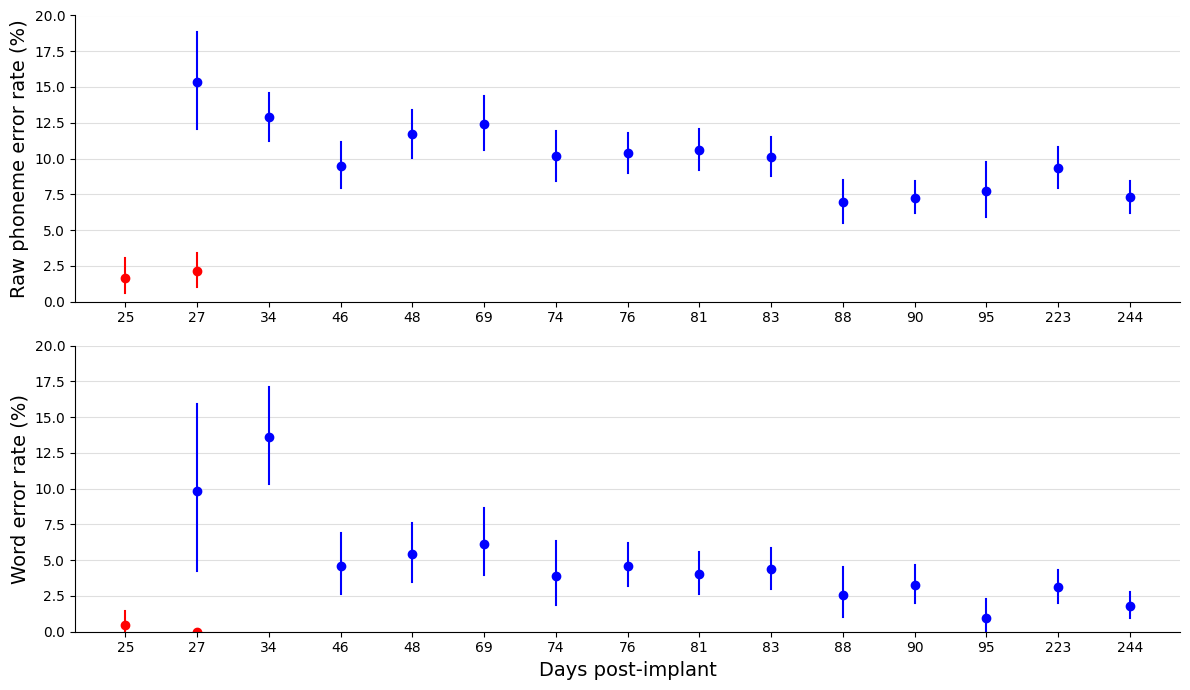

In [54]:
plt.figure(figsize=(12, 7))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

for d, day in enumerate(unique_days):
    ind = np.array(dat["post_implant_day"])==day
    for v, vocab_size in enumerate(np.unique(np.array(dat["vocab_size"])[ind])):

        if (day, vocab_size) in rper_by_day:
            rper_day = rper_by_day[(day, vocab_size)]
            ax1.plot(d, 100*rper_day[0], 'o', color='r' if vocab_size==50 else 'b', label=f'{vocab_size} words')
            ax1.plot([d, d], [100*rper_day[1], 100*rper_day[2]], color='r' if vocab_size==50 else 'b')

        if (day, vocab_size) in wer_by_day:
            wer_day = wer_by_day[(day, vocab_size)]
            ax2.plot(d, 100*wer_day[0], 'o', color='r' if vocab_size==50 else 'b', label=f'{vocab_size} words')
            ax2.plot([d, d], [100*wer_day[1], 100*wer_day[2]], color='r' if vocab_size==50 else 'b')

# axis labels
ax1.set_ylabel('Raw phoneme error rate (%)', fontsize=14)
ax2.set_xlabel('Days post-implant', fontsize=14)
ax2.set_ylabel('Word error rate (%)', fontsize=14)

# tick labels
ax1.set_xticks(np.arange(len(unique_days)))
ax1.set_xticklabels([f'{d}' for d in unique_days])
ax2.set_xticks(np.arange(len(unique_days)))
ax2.set_xticklabels([f'{d}' for d in unique_days])

# y limits
ax1.set_ylim([0, 20])
ax2.set_ylim([0, 20])

# remove splines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# grid
ax1.grid(axis='y', alpha=0.4)
ax2.grid(axis='y', alpha=0.4)

plt.tight_layout()
plt.show()